# Predição de Diabetes com Machine Learning

## Estruturação conceitual do problema de modelagem

_Com o objetivo de desenvolver e avaliar modelos supervisionados de classificação capazes de prever o diagnóstico de diabetes, utilizando dados clínicos e comportamentais, o problema foi formulado como uma tarefa de classificação supervisionada, uma vez que o conjunto de dados contém rótulos indicando qual o diagnósticom para cada indivíduo._<br>

_A base é composta majoritariamente por variáveis binárias, mas também inclui atributos ordinais e contínuos, o que torna necessária a aplicação de técnicas de normalização e padronização. Essa etapa é especialmente importante para modelos sensíveis à escala das variáveis, como o k-Nearest Neighbors (KNN)._<br>

_Além disso, foi identificado um forte desbalanceamento entre as classes, com predominância de indivíduos sem diabetes. Esse cenário pode introduzir viés no treinamento, favorecendo a classe majoritária e prejudicando a capacidade do modelo em identificar corretamente os casos positivos. Para mitigar esse efeito, serão aplicadas técnicas adequadas de validação e avaliação focadas no equilíbrio entre precisão e recall._


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate, KFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

random_seed = 42
np.random.seed(random_seed)

## Seleção Automática de Atributos

In [2]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

target = np.ravel(cdc_diabetes_health_indicators.data.targets)
all_features = cdc_diabetes_health_indicators.data.features

info_gain = mutual_info_classif(all_features, target, discrete_features='auto')
info_gain = pd.Series(info_gain, index=all_features.columns).sort_values(ascending=False)

best_features = info_gain.head(10).index.tolist()
features = all_features[best_features]

print(best_features)

['HighBP', 'GenHlth', 'PhysActivity', 'AnyHealthcare', 'CholCheck', 'Fruits', 'Veggies', 'HighChol', 'BMI', 'Sex']


In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=random_seed, stratify=target)

 _Para reduzir a dimensionalidade do problema e priorizar as variáveis mais informativas, foi aplicada a técnica de Mutual Information (Information Gain) sobre o conjunto de treino. Essa abordagem permite quantificar a dependência estatística entre cada atributo e a variável alvo, selecionando aqueles que mais contribuem para a redução da incerteza na predição do diagnóstico._<br>

_Foram selecionadas as 10 variáveis com maior ganho de informação, visando melhorar o desempenho preditivo, reduzir o risco de overfitting e simplificar o modelo final._

## Pré-processamento dos Dados

In [4]:
features_numericas = ['BMI', 'GenHlth']
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[features_numericas])
X_test_scaled = scaler.transform(X_test[features_numericas])

X_train = X_train.copy()
X_test = X_test.copy()
X_train[features_numericas] = X_train_scaled
X_test[features_numericas] = X_test_scaled

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

_As variáveis numéricas foram padronizadas utilizando o StandardScaler, garantindo que todas estivessem na mesma escala. Essa etapa é fundamental para modelos baseados em distância, como o K-Nearest Neighbors (KNN), cujo desempenho é fortemente influenciado pela magnitude das features._<br>

_O escalonamento foi ajustado exclusivamente sobre o conjunto de treino, evitando vazamento de informação para o conjunto de teste._<br>

_Além disso, foi identificado um forte desbalanceamento entre as classes. Para mitigar esse problema, aplicou-se a técnica SMOTE (Synthetic Minority Over-sampling Technique) apenas nos dados de treinamento, permitindo gerar exemplos sintéticos da classe minoritária e fornecer uma representação mais equilibrada para o processo de aprendizado._


## Treinamento e comparação entre diferentes modelos supervisionados

### Modelo com K-Nearest Neighbors

In [5]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
score = accuracy_score(y_test, y_pred_knn)
print(f"KNN Acuracy score: {score * 100:.2f}%")

KNN Acuracy score: 83.27%


In [6]:
param_grid = {
    'n_neighbors': list(range(2, 21, 2))
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_knn = grid.best_estimator_

print(f"Best k: {grid.best_params_['n_neighbors']}")

Best k: 20


In [8]:
y_pred = best_knn.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.90      0.90     65500
           1       0.35      0.33      0.34     10604

    accuracy                           0.82     76104
   macro avg       0.62      0.61      0.62     76104
weighted avg       0.82      0.82      0.82     76104



_O algoritmo K-Nearest Neighbors (KNN) foi utilizado como modelo base, por sua simplicidade e eficiência em problemas de classificação supervisionada._

_A escolha do melhor hiperparâmetro *k* foi realizada por meio de validação cruzada estratificada, utilizando GridSearch, com o objetivo de identificar o valor que maximiza o equilíbrio entre precisão e recall, considerando o desbalanceamento das classes._

_A métrica F1-score foi priorizada durante o processo de otimização, pois fornece uma avaliação mais adequada do desempenho em cenários com classes desbalanceadas._

_Após a seleção do melhor valor de *k*, o modelo final foi avaliado no conjunto de teste, permitindo uma estimativa realista de seu desempenho em dados não vistos._


#### Validação Cruzada

In [13]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': list(range(2, 21, 2))
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline_knn,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best k:", grid.best_params_['knn__n_neighbors'])


Best k: 20


_A validação cruzada estratificada foi aplicada com o objetivo de obter uma estimativa mais robusta do desempenho do modelo em dados não vistos, preservando a proporção entre as classes em cada partição._

_Foi utilizada uma abordagem de busca em grade (GridSearch) para identificar o valor ótimo do hiperparâmetro *k*, avaliando seu impacto por meio da métrica F1-score, mais adequada para cenários com classes desbalanceadas._

_Essa estratégia permite reduzir o risco de overfitting e selecionar uma configuração de modelo que apresente melhor capacidade de generalização._


### Modelo com Regressão Logística

In [14]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lgr', LogisticRegression(max_iter=1000))
])

param_grid_lgr = {
    'lgr__C': [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lgr = GridSearchCV(
    pipeline_lgr,
    param_grid_lgr,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

grid_lgr.fit(X_train, y_train)

best_lgr = grid_lgr.best_estimator_

print("Best C:", grid_lgr.best_params_)

Best C: {'lgr__C': 0.01}


In [15]:
y_pred_lgr = best_lgr.predict(X_test)

print(classification_report(y_test, y_pred_lgr))

              precision    recall  f1-score   support

           0       0.94      0.72      0.82     65500
           1       0.30      0.74      0.43     10604

    accuracy                           0.72     76104
   macro avg       0.62      0.73      0.62     76104
weighted avg       0.85      0.72      0.76     76104



_A Regressão Logística foi utilizada como modelo adicional, por sua simplicidade, interpretabilidade e ampla aplicação em problemas de classificação binária._

_A otimização do hiperparâmetro de regularização *C* foi realizada por meio de validação cruzada estratificada, utilizando GridSearch, com foco na maximização do F1-score, métrica mais apropriada para cenários com classes desbalanceadas._

_O modelo final foi então avaliado no conjunto de teste, permitindo comparar seu desempenho com outras abordagens supervisionadas._


## Comparação entre modelos

In [16]:
models = {
  'Logistic Regression': best_lgr,
  'KNN': best_knn
}

results = []

for name, model in models.items():
  y_pred = model.predict(X_test)
    
  results.append({
      'Model': name,
      'F1-score': f1_score(y_test, y_pred),
      'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
  })

pd.DataFrame(results)

,Model,F1-score,ROC-AUC
0,Logistic Regression,0.426066,0.806014
1,KNN,0.336905,0.759433


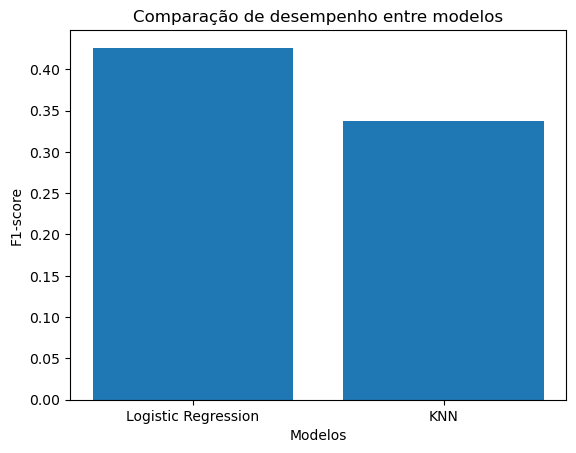

In [17]:
model_names = [r['Model'] for r in results]
f1_scores = [r['F1-score'] for r in results]

plt.figure()
plt.bar(model_names, f1_scores)
plt.xlabel("Modelos")
plt.ylabel("F1-score")
plt.title("Comparação de desempenho entre modelos")
plt.show()

_Os modelos foram comparados utilizando métricas adequadas para cenários com classes desbalanceadas, com ênfase no F1-score e na área sob a curva ROC (ROC-AUC)._

_Os resultados indicam que a Regressão Logística apresentou melhor equilíbrio entre precisão e recall, demonstrando maior capacidade de generalização em relação ao modelo KNN._

_O KNN apresentou desempenho inferior, sugerindo limitações na captura de padrões relevantes nesse conjunto de dados, possivelmente devido à alta dimensionalidade e à natureza tabular das variáveis._


In [18]:
y_pred = best_lgr.predict(X_test)
y_prob = best_lgr.predict_proba(X_test)[:,1]

precision = precision_score(y_test, y_pred, zero_division=0)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_prob)

print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Precisão: 0.30
Recall: 0.74
F1-score: 0.43
ROC-AUC: 0.81


_O modelo apresentou elevada capacidade de identificar corretamente indivíduos com diabetes, atingindo um recall de 0.74. Esse resultado é particularmente relevante em cenários de triagem em saúde, nos quais minimizar falsos negativos é prioritário._

_Por outro lado, a precisão de 0.30 indica uma taxa considerável de falsos positivos, sugerindo que o modelo tende a classificar um número elevado de indivíduos como pertencentes à classe positiva._

_O F1-score de 0.43 evidencia o desequilíbrio entre precisão e recall, enquanto o valor de ROC-AUC de 0.81 demonstra uma boa capacidade discriminativa geral, indicando que o modelo consegue separar razoavelmente bem as classes._

_Esses resultados apontam para um modelo com forte viés em favor da sensibilidade, adequado para contextos de rastreamento inicial, mas que pode demandar etapas adicionais de validação clínica para confirmação do diagnóstico._


## Matriz de Confusão

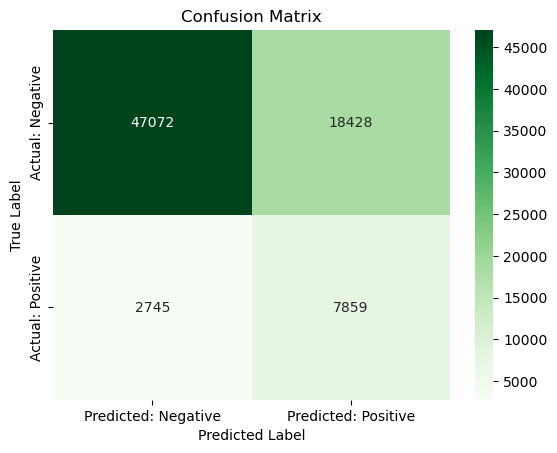

In [19]:
cm = confusion_matrix(y_test, y_pred_lgr)
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=['Predicted: Negative', 'Predicted: Positive'], yticklabels=['Actual: Negative', 'Actual: Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

_A matriz de confusão evidencia que o modelo apresenta elevada capacidade de identificar corretamente indivíduos sem diabetes, indicando boa especificidade. Além disso, observa-se um número significativo de verdadeiros positivos, refletindo a boa sensibilidade do classificador. No entanto, a presença de uma quantidade considerável de falsos positivos indica uma tendência do modelo em superestimar a classe positiva, o que impacta diretamente a precisão._

_Embora o número de falsos negativos seja relativamente baixo, sua minimização é crítica em contextos clínicos, uma vez que erros desse tipo podem retardar o diagnóstico e comprometer o início precoce do tratamento._
_Dessa forma, os resultados indicam que o modelo é adequado para aplicações de triagem inicial, priorizando a detecção de possíveis casos, ainda que à custa de uma maior taxa de alarmes falsos._


## Otimização da Regressão Logística

In [20]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

logreg = LogisticRegression(
    solver='saga',
    class_weight='balanced',
    max_iter=2000,
    random_state=random_seed
)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


In [21]:
grid = GridSearchCV(
    logreg,
    param_grid,
    scoring=scoring,
    refit='f1',
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

pd.DataFrame(grid.cv_results_)[[
    'params', 
    'mean_test_precision', 
    'mean_test_recall',
    'mean_test_f1',
    'mean_test_roc_auc'
]].sort_values(by='mean_test_f1', ascending=False).head()


c:\Users\Leiil\miniconda3\envs\meu_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


,params,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
3,"{'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}",0.725476,0.745613,0.735402,0.807343
14,"{'C': 100, 'l1_ratio': 0.5, 'penalty': 'elasti...",0.725425,0.745600,0.735370,0.807336
13,"{'C': 100, 'l1_ratio': 0.5, 'penalty': 'l2'}",0.725425,0.745600,0.735370,0.807336
11,"{'C': 10, 'l1_ratio': 0.5, 'penalty': 'elastic...",0.725425,0.745600,0.735370,0.807336
12,"{'C': 100, 'l1_ratio': 0.5, 'penalty': 'l1'}",0.725425,0.745600,0.735370,0.807336


_Foi conduzida uma busca sistemática por hiperparâmetros, avaliando diferentes valores de regularização (*C*) e tipos de penalização (*L1*, *L2* e *ElasticNet*), além da aplicação de balanceamento automático das classes por meio do parâmetro `class_weight='balanced'`._

_A avaliação foi realizada utilizando validação cruzada estratificada, considerando múltiplas métricas de desempenho, incluindo precisão, recall, F1-score e ROC-AUC. Os resultados indicaram estabilidade nas métricas ao longo das diferentes configurações, sugerindo boa robustez do modelo. Observou-se melhora significativa na métrica de precisão, que atingiu aproximadamente 0.73, reduzindo substancialmente a taxa de falsos positivos, sem comprometer de forma relevante o recall._

_O F1-score apresentou evolução consistente, refletindo um equilíbrio mais adequado entre precisão e sensibilidade. Esses resultados tornam o modelo mais adequado para aplicações de triagem clínica, nas quais é desejável minimizar falsos negativos, sem gerar um número excessivo de alarmes falsos._

_Apesar de não apresentar desempenho excepcional, o modelo demonstrou capacidade satisfatória de generalização, alcançando uma precisão média próxima de 70%, o que o torna uma solução viável como ferramenta de apoio à decisão em contextos de rastreamento populacional._
